# Imports

In [17]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

# Read Data

In [3]:
df = pd.read_csv('../02_analysis/df_good.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_8769/882331396.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../02_analysis/df_good.csv')


# Baseline Model

## Data Munge

In [11]:
# Convert 'trial_date' to datetime and sort the dataframe
df['trial_date'] = pd.to_datetime(df['trial_date'])
df_sorted = df.sort_values(by=['PID', 'trial_date'])

# Create shifted columns
df['sr_gap_heuristic_d1'] = df.groupby('PID')['sr_gap_heuristic'].shift(-1)
df['sr_gap_heuristic_d2'] = df.groupby('PID')['sr_gap_heuristic'].shift(-2)
df['sr_gap_heuristic_d3'] = df.groupby('PID')['sr_gap_heuristic'].shift(-3)

In [12]:
cols = [col for col in df.columns if 'heuristic' in col]
cols

In [15]:
df[cols]

,sr_gap_heuristic,sr_gap_heuristic_residual,sr_gap_heuristic_intercept,sr_gap_heuristic_slope,sr_gap_heuristic_d1,sr_gap_heuristic_d2,sr_gap_heuristic_d3
0,5.00,-12.693303,17.753776,-0.060473,15.25,46.35,43.70
1,15.25,-2.382829,17.753776,-0.060473,46.35,43.70,45.60
2,46.35,28.777644,17.753776,-0.060473,43.70,45.60,11.55
3,43.70,26.188117,17.753776,-0.060473,45.60,11.55,4.10
4,45.60,28.148591,17.753776,-0.060473,11.55,4.10,17.35
...,...,...,...,...,...,...,...
8920,58.05,16.075780,47.125900,-0.063601,26.25,67.35,52.15
8921,26.25,-15.660619,47.125900,-0.063601,67.35,52.15,NaN
8922,67.35,25.502982,47.125900,-0.063601,52.15,NaN,NaN
8923,52.15,10.366583,47.125900,-0.063601,NaN,NaN,NaN


## RMSE

In [35]:
# Define a function to calculate MSE for a specific lag
def calculate_mse(data, actual, predicted):
    data = data.dropna(subset=[actual, predicted])  # Ensure no NaN values
    rmse = np.sqrt(mean_squared_error(data[actual], data[predicted]))
    return rmse

# Group by 'PID' and apply the MSE calculation for each prediction day
rmse_results = df.groupby('PID').apply(lambda x: pd.Series({
    'RMSE_Day_1': calculate_mse(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d1'),
    'RMSE_Day_2': calculate_mse(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d2'),
    'RMSE_Day_3': calculate_mse(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d3')
})).reset_index()

In [36]:
rmse_results

,PID,RMSE_Day_1,RMSE_Day_2,RMSE_Day_3
0,0151d9f1-1644-4437-805e-02f5e244a690,12.484630,14.869927,14.895803
1,02f48bee-6e86-437c-9394-10ae57dadd14,26.379210,24.527410,25.394194
2,0501ba67-3406-4779-aff1-878a0e9f7885,26.945275,30.797342,32.152243
3,06af7782-cd70-4938-8e67-b6d98b34b665,14.664723,14.417367,18.015907
4,075f7c4e-edea-4d64-8844-f046a1beb770,18.910780,21.273065,19.474681
...,...,...,...,...
100,fb6c8f5a-f92d-4af8-9f87-73ffd4e21f98,24.921687,28.546079,28.667586
101,fc490430-6a41-4853-a2cf-ae0b15265cb6,24.212830,25.429221,26.734689
102,fed3a16b-c5a3-4a84-a111-32b7574e04b5,9.655825,9.885494,8.897692
103,fee5cd07-329a-4f07-bb1a-913dfa09e3b4,19.245491,20.687113,20.787086


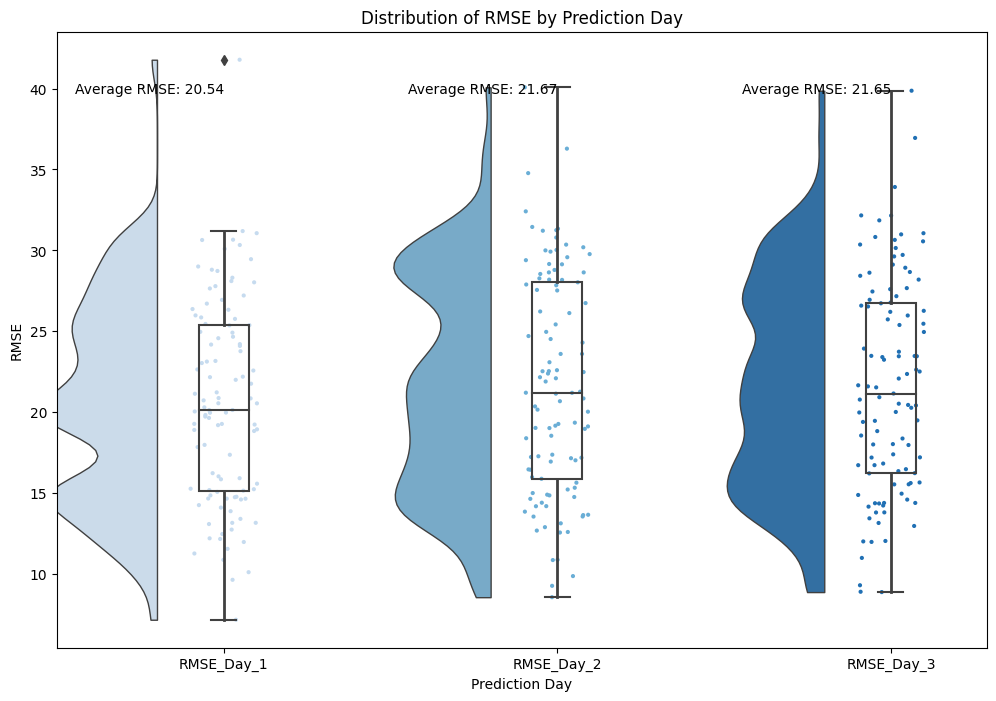

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt

# Melting the dataframe for suitable plotting
plot_data = rmse_results.melt(id_vars=['PID'], var_name='Prediction_Day', value_name='RMSE')

# Calculate average MSE for each day
average_mse = plot_data.groupby('Prediction_Day')['RMSE'].mean().reset_index()
average_mse['label'] = average_mse['RMSE'].apply(lambda x: f'Average RMSE: {x:.2f}')

# Creating a raincloud plot
plt.figure(figsize=(12, 8))
ax = pt.RainCloud(data=plot_data, x='Prediction_Day', y='RMSE', palette='Blues', bw=0.2)

# Title and labels
plt.title('Distribution of RMSE by Prediction Day')
plt.xlabel('Prediction Day')
plt.ylabel('RMSE')

# Adding average MSE labels to the plot
for i, row in average_mse.iterrows():
    plt.text(x=i, y=plot_data['RMSE'].max() * .95, s=row['label'], horizontalalignment='right')

plt.show()

## Correlation

In [28]:
from scipy.stats import pearsonr

def calculate_correlation(data, actual, predicted):
    valid_data = data.dropna(subset=[actual, predicted])
    if len(valid_data) < 2:
        return np.nan  # Return NaN if not enough data to calculate correlation
    correlation, _ = pearsonr(valid_data[actual], valid_data[predicted])
    return correlation

# Group by 'PID' and apply the correlation calculation for each prediction day
correlation_results = df.groupby('PID').apply(lambda x: pd.Series({
    'Correlation_Day_1': calculate_correlation(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d1'),
    'Correlation_Day_2': calculate_correlation(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d2'),
    'Correlation_Day_3': calculate_correlation(x, 'sr_gap_heuristic', 'sr_gap_heuristic_d3')
})).reset_index()

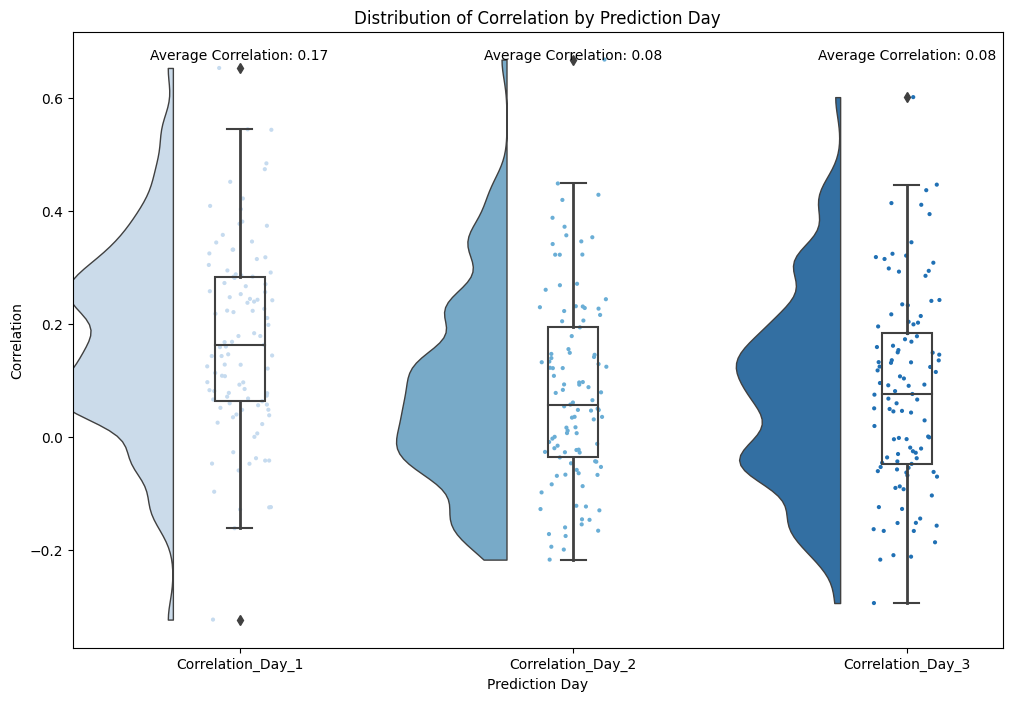

In [32]:
# Melting the dataframe for suitable plotting
plot_data = correlation_results.melt(id_vars=['PID'], var_name='Prediction_Day', value_name='Correlation')

# Calculate average correlation for each day
average_corr = plot_data.groupby('Prediction_Day')['Correlation'].mean().reset_index()
average_corr['label'] = average_corr['Correlation'].apply(lambda x: f'Average Correlation: {x:.2f}')

# Creating a raincloud plot
plt.figure(figsize=(12, 8))
ax = pt.RainCloud(data=plot_data, x='Prediction_Day', y='Correlation', palette='Blues', bw=0.2)

# Title and labels
plt.title('Distribution of Correlation by Prediction Day')
plt.xlabel('Prediction Day')
plt.ylabel('Correlation')

# Adding average correlation labels to the plot
for i, row in average_corr.iterrows():
    plt.text(x=i, y=plot_data['Correlation'].max(), s=row['label'], horizontalalignment='center')

plt.show()

# Mixed Effects Models

## Gap

In [42]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
cols = ['PID',
        'trial_date',
        'sr_gap_heuristic',
        'sr_gap_heuristic_d1',
        'sr_gap_heuristic_d2',
        'sr_gap_heuristic_d3'
        ]
df_pred = df[cols].copy()
df_pred.dropna(inplace=True)

results = {}
pred_columns = ['sr_gap_heuristic_d1', 'sr_gap_heuristic_d2', 'sr_gap_heuristic_d3']
for col in pred_columns:
    model = MixedLM(df_pred[col], df_pred[['sr_gap_heuristic']], groups=df_pred['PID'])
    result = model.fit()
    df_pred[col + '_pred'] = result.fittedvalues  # Store predictions for RMSE calculation
    results[col] = result

# Output the summary of one of the models if needed
print(results['sr_gap_heuristic_d1'].summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sr_gap_heuristic_d1
No. Observations: 6988    Method:             REML               
No. Groups:       105     Scale:              268.4983           
Min. group size:  21      Log-Likelihood:     -29758.8843        
Max. group size:  81      Converged:          Yes                
Mean group size:  66.6                                           
-----------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
sr_gap_heuristic        0.197    0.012 16.561 0.000  0.174  0.220
Group Var            1233.337   10.744                           



In [43]:
rmse_scores = {}
for col in pred_columns:
    actual = df_pred[col].dropna()
    predicted = df_pred[col + '_pred'][actual.index]  # Ensure alignment of indices
    mse = mean_squared_error(actual, predicted)
    rmse_scores[col] = np.sqrt(mse)

# Display the RMSE scores
print(rmse_scores)

{'sr_gap_heuristic_d1': 16.261564564708788, 'sr_gap_heuristic_d2': 16.48465638065982, 'sr_gap_heuristic_d3': 16.33214734067258}


## Gap + Net Affect

In [44]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
cols = ['PID',
        'trial_date',
        'sr_gap_heuristic',
        'sr_gap_heuristic_d1',
        'sr_gap_heuristic_d2',
        'sr_gap_heuristic_d3',
        'sr_affect_net_avg'
        ]
df_pred = df[cols].copy()
df_pred.dropna(inplace=True)

results = {}
pred_columns = ['sr_gap_heuristic_d1', 'sr_gap_heuristic_d2', 'sr_gap_heuristic_d3']
for col in pred_columns:
    model = MixedLM(df_pred[col], df_pred[['sr_gap_heuristic', 'sr_affect_net_avg']], groups=df_pred['PID'])
    result = model.fit()
    df_pred[col + '_pred'] = result.fittedvalues  # Store predictions for RMSE calculation
    results[col] = result

# Output the summary of one of the models if needed
print(results['sr_gap_heuristic_d1'].summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sr_gap_heuristic_d1
No. Observations: 6823    Method:             REML               
No. Groups:       105     Scale:              267.8141           
Min. group size:  16      Log-Likelihood:     -29051.1780        
Max. group size:  81      Converged:          Yes                
Mean group size:  65.0                                           
-----------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
sr_gap_heuristic        0.210    0.013 16.663 0.000  0.186  0.235
sr_affect_net_avg       0.573    0.245  2.340 0.019  0.093  1.053
Group Var            1189.945   10.440                           



In [46]:
rmse_scores = {}
for col in pred_columns:
    actual = df_pred[col].dropna()
    predicted = df_pred[col + '_pred'][actual.index]  # Ensure alignment of indices
    mse = mean_squared_error(actual, predicted)
    rmse_scores[col] = np.sqrt(mse)

# Display the RMSE scores
print(rmse_scores)

{'sr_gap_heuristic_d1': 16.236674085423978, 'sr_gap_heuristic_d2': 16.488029222619012, 'sr_gap_heuristic_d3': 16.273360147514058}


# ML Models

## Test 1

### Feature Engineering

In [58]:
# Example feature engineering: Mean encoding for PIDs
pid_mean = df.groupby('PID')['sr_gap_heuristic'].transform('mean')
df['sr_gap_heuristic_mean'] = pid_mean

pid_mean = df.groupby('PID')['sr_affect_net_avg'].transform('mean')
df['sr_affect_subject_mean'] = pid_mean

df['sr_gap_heuristic_residual'] = df['sr_gap_heuristic'] - df['sr_gap_heuristic_mean']
df['sr_affect_residual'] = df['sr_affect_net_avg'] - df['sr_affect_subject_mean']

In [59]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

# Prepare features and target
X = df[['sr_gap_heuristic', 'sr_affect_net_avg', 'sr_gap_heuristic_mean', 'sr_gap_heuristic_residual', 'sr_affect_subject_mean', 'sr_affect_residual']]  # plus other features as needed
y = df['sr_gap_heuristic_d1']  # Predicting Day 1 gap as an example
groups = df['PID']

# Setup Group K-Fold to respect PID groups
gkf = GroupKFold(n_splits=5)

# Define the model
model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)

# Perform group k-fold cross-validation
rmse_scores = []
for train_idx, test_idx in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Output the RMSE scores
print("RMSE scores:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

ModuleNotFoundError: No module named 'lightgbm'